# CMI Code for Meshing and Clipping Subduction Zone

#### Libraries and necessary functions

In [7]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np # Numerical analysis
import gmsh # Creation of fault models
import meshio # Interaction between fault model files and Python
import matplotlib.pyplot as plt # Visualize 
from pyproj import Proj
import pyproj
from geopandas import geoseries
%matplotlib widget

In [8]:
# Define some basic coordinate transformation functions
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z

def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return azimuth, elevation, r

def wrap2360(lon):
    lon[np.where(lon < 0.0)] += 360.0
    return lon

#### Read in subduction zone mesh and parse

In [9]:
# Read in source fault
filename = "japan.msh"
mesh = dict()
meshobj = meshio.read(filename)
mesh["file_name"] = filename
mesh["points"] = meshobj.points
mesh["verts"] = meshio.CellBlock("triangle", meshobj.get_cells_type("triangle")).data
ntri = len(mesh["verts"])

# Expand mesh coordinates
mesh["lon1"] = mesh["points"][mesh["verts"][:, 0], 0]
mesh["lon2"] = mesh["points"][mesh["verts"][:, 1], 0]
mesh["lon3"] = mesh["points"][mesh["verts"][:, 2], 0]
mesh["lat1"] = mesh["points"][mesh["verts"][:, 0], 1]
mesh["lat2"] = mesh["points"][mesh["verts"][:, 1], 1]
mesh["lat3"] = mesh["points"][mesh["verts"][:, 2], 1]
mesh["dep1"] = mesh["points"][mesh["verts"][:, 0], 2]
mesh["dep2"] = mesh["points"][mesh["verts"][:, 1], 2]
mesh["dep3"] = mesh["points"][mesh["verts"][:, 2], 2]
mesh["centroids"] = np.mean(mesh["points"][mesh["verts"], :], axis=1)

# Cartesian coordinates in meters
mesh["x1"], mesh["y1"], mesh["z1"] = sph2cart(
    mesh["lon1"],
    mesh["lat1"],
    RADIUS_EARTH + KM2M * mesh["dep1"],
)
mesh["x2"], mesh["y2"], mesh["z2"] = sph2cart(
    mesh["lon2"],
    mesh["lat2"],
    RADIUS_EARTH + KM2M * mesh["dep2"],
)
mesh["x3"], mesh["y3"], mesh["z3"] = sph2cart(
    mesh["lon3"],
    mesh["lat3"],
    RADIUS_EARTH + KM2M * mesh["dep3"],
)
# Cartesian triangle centroids
mesh["x_centroid"] = (mesh["x1"] + mesh["x2"] + mesh["x3"]) / 3.0
mesh["y_centroid"] = (mesh["y1"] + mesh["y2"] + mesh["y3"]) / 3.0
mesh["z_centroid"] = (mesh["z1"] + mesh["z2"] + mesh["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(mesh["lon2"] - mesh["lon1"]), np.deg2rad(mesh["lat2"] - mesh["lat1"]), (1 + KM2M * mesh["dep2"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(mesh["lon3"] - mesh["lon1"]), np.deg2rad(mesh["lat3"] - mesh["lat1"]), (1 + KM2M * mesh["dep3"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
mesh["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(mesh["nv"][:, 0], mesh["nv"][:, 1], mesh["nv"][:, 2])
mesh["strike"] = wrap2360(-np.rad2deg(azimuth))
mesh["dip"] = 90 - np.rad2deg(elevation)
mesh["dip_flag"] = mesh["dip"] != 90


## Mesh CMI and clip the fault mesh to match

#### Helpful functions for CMI depth contour determination 

In [35]:
# Helpful functions for determining points along triangle legs

# There are 6 possible of tri verts [A,B,C] where at least one is above and at least one is below the plane (spanning depth contour).
# (where T=below and F=above the plane)
# [TTF], [TFT], [TFF], [FTT], [FTF], [FFT]
# After determining the combo (which legs are crossing the plane), the points along the depth contour are calculated on each leg respectively.
# For three triangle vertices: [A,B,C]
# Where each vertex consists of [*lon*, *lat*, *dep*]
# To find point P, along line segment **AB** at a depth of 60 km:
# Each element in point P can be found using an endpoint of the line segment, and adding a scalar quantity (t) of the line segment's direction vector.

# *dep*P = *dep***A** + (t * **AB**[2])
# But we know that the depth will always be 60 for the depth contour

# 60 = *dep***A** + (t * [*dep***B** - *dep***A**])
# t = (60 - *dep***A**) / (*dep***B** - *dep***A**)
# So because we can find a value for scalar t, we can determine the other values of elements in point P.

def direction_vector(p1, p2):
    dir_vec = [(p2[0] - p1[0]), (p2[1] - p1[1]), (p2[2] - p1[2])]
    return dir_vec


# a point P on a line segment will be P = t * direction_vector + end_point
# where t is a scalar amount, here, determined by the known plane_depth
# this is done for each element of point P, (x,y,z)
def point_grab(vector, t, start):
    point = [(t*vector[0] + start[0]), (t*vector[1] + start[1]), (t*vector[2] + start[2])]
    return point

# for each point, the desired depth value
# is the same as plane_depth
# so z is always known, and we can create the scalar quantity
# for the rest of the points based upon it
# plane_depth = z1 + t(z2 - z1)
# t = (plane_depth - z1) / (z2 - z1)
def scalar(p1, p2, depth):
    t = (depth - p1[2]) / (p2[2] - p1[2])
    return t

#### Determine points along the depth contour based on triangle legs

In [36]:
# Create depth contour points using triangle elements spanning the CMI depth

# depth of the CMI
plane_depth = 60

# triangle node values and empty list
# each row is a triangle element [lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3]
nodes = np.empty((mesh["lon1"].size, 9))
nodes[:,0] = mesh["lon1"] ; nodes[:,1] = mesh["lat1"] ; nodes[:,2] = abs(mesh["dep1"])
nodes[:,3] = mesh["lon2"] ; nodes[:,4] = mesh["lat2"] ; nodes[:,5] = abs(mesh["dep2"])
nodes[:,6] = mesh["lon3"] ; nodes[:,7] = mesh["lat3"] ; nodes[:,8] = abs(mesh["dep3"])

sort_by = [] # python implements lists as dynamic arrays.
# for each row (triangle element), check if the depths span the contour needed
# if the depths span the contour, that means the triangle legs cross 60 km depth
# and a point on two legs can be included in the contour 

for i in range(np.size(nodes, 0)):
    node_depth = [nodes[i,2], nodes[i,5], nodes[i,8]] # access the depth values of a triangle element
    if (max(node_depth) > plane_depth > min(node_depth)):
        sort_by.append(True)
    else:
        sort_by.append(False)

bool_mask = np.array(sort_by) 

# construct an array where each row is a triangle (lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3)
# which spans the depth contour, sorted by the boolean mask made earlier
tri_elem = np.empty((bool_mask.sum(), 9)) #sum is adding up True=1 False=0
tri_elem[::] = nodes[::][bool_mask] # grab triangle elements based on the depth spanning criteria

# there are six combinations of point arrangements, but only 3 unique combinations of line segments ac, ab, bc
# array for points along the depth contour (including duplicates), each element will have two points
depth_all = np.empty(((2*np.size(tri_elem, 0)), 3)) 
m = 0 # row number of the current point, initialized outside of loop

# determine line segments crossing plane, determine point coordinates on the line segment
# add the points to the array
for j in range(np.size(tri_elem, 0)):
    a = tri_elem[j,[0,1,2]] #node a
    b = tri_elem[j,[3,4,5]] #node b
    c = tri_elem[j,[6,7,8]] #node c

    # create direction vectors for line segments
    # all three are created to avoid code clutter in if-statements
    ab = direction_vector(a, b)
    ac = direction_vector(a, c)
    bc = direction_vector(b, c)

    # determine the combination of nodes above and below the CMI plane
    combo = [bool(a[2]>plane_depth), bool(b[2]>plane_depth), bool(c[2]>plane_depth)]

    # ab, ac are the triangle legs when a is alone above or below the line
    if ((combo==[True, False, False]) or (combo==[False,True,True])):
        t1 = scalar(a, b, plane_depth)
        t2 = scalar(a, c, plane_depth)

        # each point along the depth contour can be found using an end point, plus a scalar quantity along a direction vector
        p1 = point_grab(ab, t1, a) 
        p2 = point_grab(ac, t2, a)

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row

    # ab, bc when b is alone above or below the line
    elif ((combo==[True,False,True]) or (combo==[False,True,False])):
        t1 = scalar(a, b, plane_depth)
        t2 = scalar(b, c, plane_depth)

        p1 = point_grab(ab, t1, a)
        p2 = point_grab(bc, t2, b)

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row

    # only remaining line segment combination is [ac, bc], where vertex C is isolated above/below
    else:
        t1 = scalar(a, c, plane_depth)
        t2 = scalar(b, c, plane_depth)

        #each of the three components of point1 are endpoint, plus a scalar quantity of the direction vector
        p1 = point_grab(ac, t1, a)
        p2 = point_grab(bc, t2, b) # the z component will always be 60 km or plane_depth, including the equation helps clarify other indicies

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row


# triangles share legs, so points are repeated unnecessarily, this takes only the unique rows in the 2D array
df = pd.DataFrame(depth_all, columns=["lon", "lat", "dep"])
depth_contour = df.drop_duplicates(subset=["lon"])
depth_contour = np.array(df.drop_duplicates(subset="lat"))

# using pandas not numpy, because numpy will sort the columns, but that shuffles lon, lat pairs apart
if 0:
    plt.close('all')
    fig, ax = plt.subplots()
    plt.scatter(depth_contour[:,0], depth_contour[:,1])
    plt.show()

In [37]:
# Mesh the CMI based upon lower depth extent of afterslip ~60km

#sort points by increasing latitude
indicies = np.argsort( depth_contour[:,1] )
depth_contour = depth_contour[indicies]

# separately add on the corners of the CMI
min_lon = 137 # minimum longitude value for corner
min_lat = 34
max_lat = np.max(depth_contour[:,1]+0.5) # maximum latitude for corner

# corner points starting from lower left and moving counterclockwise
corner_points = np.array([[min_lon, min_lat, plane_depth], [depth_contour[0,0], min_lat, plane_depth], [min_lon, max_lat, plane_depth], [np.max(depth_contour[:,0]), max_lat, plane_depth]])

# total points along the perimiter of the CMI mesh
mesh_edge = np.concatenate((depth_contour, corner_points))

# fig, ax = plt.subplots()
# ax.scatter(mesh_edge[:, 0], mesh_edge[:, 1])
# plt.show()

cx = mesh_edge[:,0]
cy = mesh_edge[:,1]
cz = -1*mesh_edge[:,2] # depth is negative

## BEGIN GMSH

char_len = 0.75 # smaller is good for degrees
n_points = np.shape(depth_contour)[0] # number of depth contour points
num_surf = np.shape(depth_contour)[0]
num_lines = np.shape(mesh_edge)[0] #num lines is the same as the total number of points

if gmsh.isInitialized() == 0:
    gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)
gmsh.clear()

# Define points
gmsh.model.geo.addPoint(cx[-4], cy[-4], cz[-4], char_len, 0) #lower left corner because corner points were added last in the mesh_points
gmsh.model.geo.addPoint(cx[-3], cy[-3], cz[-3], char_len, 1)
for j in range(int(n_points)): # depth contour points
    gmsh.model.geo.addPoint(cx[j], cy[j], cz[j], char_len, j+2) 

gmsh.model.geo.addPoint(cx[-1], cy[-1], cz[-1], char_len, j+3) #upper right corner
gmsh.model.geo.addPoint(cx[-2], cy[-2], cz[-2], char_len, j+4) #upper left corner

# add lines between the points to complete the perimiter
for i in range(int(num_lines-1)):
    gmsh.model.geo.addLine(i, i+1, i)
gmsh.model.geo.addLine(i+1, 0, i+1) #complete the loop

gmsh.model.geo.synchronize()

# define curve loop counterclockwise
gmsh.model.geo.addCurveLoop(list(range(0, i+2)), 1)

gmsh.model.geo.addPlaneSurface([1], 1)

# Finish writing geo attributes
gmsh.model.geo.synchronize()

gmsh.write('horiz' + '.geo_unrolled')

# Generate mesh
gmsh.model.mesh.generate(2) #meshed in spherical because the depth being in km isn't as important when it's flat

gmsh.write('horiz' + '.msh')
gmsh.finalize()  

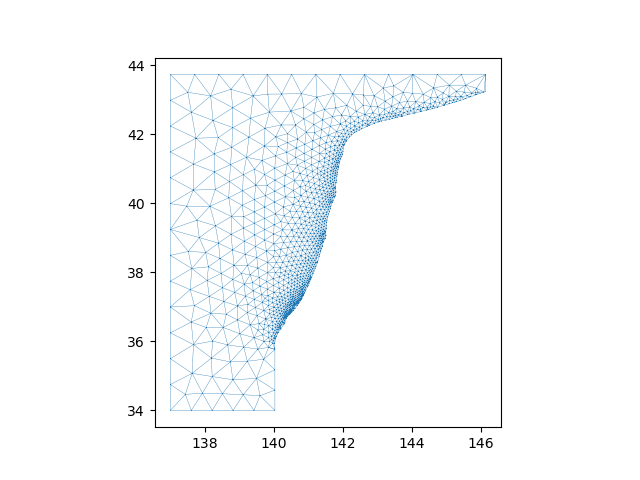

In [38]:
# Read and parse mesh
horiz = dict()
# information about the CMI mesh is read in, and stored in a dictionary just like for fault mesh earlier
horizobj = meshio.read("horiz.msh") 
horiz["points"] = horizobj.points
horiz["verts"] = meshio.CellBlock("triangle", horizobj.get_cells_type("triangle")).data

keep_el = np.ones(len(horiz["verts"])).astype(bool)

for i in range(len(horiz["verts"])):
    tri_test = np.shape(np.unique(horiz["points"][horiz["verts"][i,:],:],axis=0))[0]
    if tri_test != 3:
        keep_el[i] = False

horiz["verts"] = horiz["verts"][keep_el,:]

# Expand mesh coordinates
horiz["lon1"] = horiz["points"][horiz["verts"][:, 0], 0]
horiz["lon2"] = horiz["points"][horiz["verts"][:, 1], 0]
horiz["lon3"] = horiz["points"][horiz["verts"][:, 2], 0]
horiz["lat1"] = horiz["points"][horiz["verts"][:, 0], 1]
horiz["lat2"] = horiz["points"][horiz["verts"][:, 1], 1]
horiz["lat3"] = horiz["points"][horiz["verts"][:, 2], 1]
horiz["dep1"] = horiz["points"][horiz["verts"][:, 0], 2]
horiz["dep2"] = horiz["points"][horiz["verts"][:, 1], 2]
horiz["dep3"] = horiz["points"][horiz["verts"][:, 2], 2]
horiz["centroids"] = np.mean(horiz["points"][horiz["verts"], :], axis=1)

# Cartesian coordinates in meters
horiz["x1"], horiz["y1"], horiz["z1"] = sph2cart(
    horiz["lon1"],
    horiz["lat1"],
    RADIUS_EARTH + KM2M * horiz["dep1"],
)
horiz["x2"], horiz["y2"], horiz["z2"] = sph2cart(
    horiz["lon2"],
    horiz["lat2"],
    RADIUS_EARTH + KM2M * horiz["dep2"],
)
horiz["x3"], horiz["y3"], horiz["z3"] = sph2cart(
    horiz["lon3"],
    horiz["lat3"],
    RADIUS_EARTH + KM2M * horiz["dep3"],
)
# Cartesian triangle centroids
horiz["x_centroid"] = (horiz["x1"] + horiz["x2"] + horiz["x3"]) / 3.0
horiz["y_centroid"] = (horiz["y1"] + horiz["y2"] + horiz["y3"]) / 3.0
horiz["z_centroid"] = (horiz["z1"] + horiz["z2"] + horiz["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(horiz["lon2"] - horiz["lon1"]), np.deg2rad(horiz["lat2"] - horiz["lat1"]), (1 + KM2M * horiz["dep2"] / RADIUS_EARTH) - (1 + KM2M * horiz["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(horiz["lon3"] - horiz["lon1"]), np.deg2rad(horiz["lat3"] - horiz["lat1"]), (1 + KM2M * horiz["dep3"] / RADIUS_EARTH) - (1 + KM2M * horiz["dep1"] / RADIUS_EARTH)])
horiz["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(horiz["nv"][:, 0], horiz["nv"][:, 1], horiz["nv"][:, 2])
horiz["strike"] = wrap2360(-np.rad2deg(azimuth))
horiz["dip"] = 90 - np.rad2deg(elevation)
horiz["dip_flag"] = horiz["dip"] != 90

# Draw the fault 
plt.close('all')
fig, ax = plt.subplots()
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()

In [39]:
# create clipped fault mesh based upon CMI meshing, MUST have run CMI depth contour cell without changing anything, the order of elements in arrays is important

# there are 6 possibilities for mesh / plane intersection of the triangles
# given 3 nodes [a,b,c], where T is below and F is above the clipping plane, 
# [TFF], [TTF], [TFT], [FTF], [FFT], [FTT]
# these possibilities are numbered 1 through 6
# if 1: keep node a, and add points along ab and ac calculated from the depth contour
# if 2: [a, bc, ac] [a, b, ac]
# if 3: [a, bc, ab] [a, c, bc]
# if 4: [b, ab, bc]
# if 5: [c, ac, bc]
# if 6: [b, ac, ab] [b, c, ac]

# add new points calculated along line segments to the old points
df = pd.DataFrame(depth_all, columns=["lon", "lat", "dep"])
depth_contour = df.drop_duplicates(subset=["lon"])
depth_contour = np.array(depth_contour.drop_duplicates(subset="lat")) # order of elements determined by order of tri_elem, not sorted

num_old = len((mesh["points"][:,0]))
new_points = np.empty(((num_old + len(depth_contour[:,0])), 3))

# add the old points as well as the new points to a shared array, contains points deeper than needed for now
new_points[0:num_old, [0,1,2]] = mesh["points"][:, [0,1,2]]
new_points[num_old:, [0,1]] = depth_contour[:,[0,1]]
new_points[num_old:, 2] = -1*depth_contour[:,2] # negative to match previous convention for points

# determine the combination possibility that each element is
combo_list = np.empty((len(tri_elem[:,0]), 3))
num_extra = 0

for j in range(np.size(tri_elem, 0)):
    a = tri_elem[j,[0,1,2]] #node a
    b = tri_elem[j,[3,4,5]] #node b
    c = tri_elem[j,[6,7,8]] #node c

    # determine the combination of nodes above and below the CMI plane
    combo = [bool(a[2]<plane_depth), bool(b[2]<plane_depth), bool(c[2]<plane_depth)]
    combo_list[j,0] = combo[0]
    combo_list[j,1] = combo[1]
    combo_list[j,2] = combo[2]

    if sum(combo)==2: # if more than two nodes are above the CMI depth, the remaining shape is a quadrilateral and two triangles must be created from it
        num_extra += 1

# create array of new triangle elements
new_tri_elem = np.zeros(((len(tri_elem[:,0])+num_extra), 9)) # as many as previously plus the new ones
point_count = 0
tri_count = 0

for i in range(len(combo_list[:,0])):
    temp_list = [combo_list[i,0], combo_list[i,1], combo_list[i,2]]

    if temp_list==[True,False,False]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i,[0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add ac
        tri_count += 1
    elif temp_list==[True,True,False]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i,[0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add ac
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add bc
        tri_count += 1
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count-1, [0,1,2]] # add node ac
        tri_count += 1
    elif temp_list==[True,False,True]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node bc
        tri_count += 1
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = tri_elem[i, [6,7,8]] # keep node c
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count-1, [0,1,2]] # add node bc
        tri_count += 1
    elif temp_list==[False,True,False]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node bc
        tri_count += 1
    elif temp_list==[False,False,True]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [6,7,8]] # keep node c
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ac
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node bc
        tri_count += 1
    elif temp_list==[False,True,True]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ac
        tri_count += 1
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [3,4,5]] = tri_elem[i, [6,7,8]] # keep node c
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count-1, [0,1,2]] # add node ac
        tri_count += 1



#depth val of new_tri_elem needs to be negative to match the points
new_tri_elem[:,[2,5,8]] = -1*new_tri_elem[:,[2,5,8]]
new_verts = np.empty((len(new_tri_elem[:,0]), 3))

# determine the indecies of points for triangle vertexes
for m in range(len(new_tri_elem[:,0])):
    points = np.round(new_points, decimals=9)
    lon1 = round(new_tri_elem[m,0], 9) ; lat1 = round(new_tri_elem[m,1], 9) ; dep1 = round(new_tri_elem[m,2], 9)
    lon2 = round(new_tri_elem[m,3], 9) ; lat2 = round(new_tri_elem[m,4], 9) ; dep2 = round(new_tri_elem[m,5], 9)
    lon3 = round(new_tri_elem[m,6], 9) ; lat3 = round(new_tri_elem[m,7], 9) ; dep3 = round(new_tri_elem[m,8], 9)
    index1 = np.where((points[:,0]==lon1) & (points[:,1]==lat1) & (points[:,2]==dep1))[0]
    index2 = np.where((points[:,0]==lon2) & (points[:,1]==lat2) & (points[:,2]==dep2))[0]
    index3 = np.where((points[:,0]==lon3) & (points[:,1]==lat3) & (points[:,2]==dep3))[0]
    new_verts[m,0] = int(index1[0])
    new_verts[m,1] = int(index2[0])
    new_verts[m,2] = int(index3[0])


# bool mask was defined for elem spanning depth contour, need opposite now
flip_bool = ~bool_mask
old_verts = mesh["verts"][flip_bool]

# find points that are lower than the depth contour and drop them
too_deep = np.where(new_points[:,2] < -60)[0] # rows of points that have values too deep
big_mask = np.isin(old_verts, too_deep, invert=True)
mask = []
for n in range(len(big_mask[:,0])):
    if big_mask[n].all():
        mask.append(True)
    else:
        mask.append(False)
mask = np.array(mask) # True = tri elem above the maximum depth

new_verts = new_verts.astype(int) # switch from float so that the indecies are compatible
total_verts = np.vstack((old_verts[::][mask], new_verts)).astype(int)


# fault = meshio.Mesh(np.array(new_points), cells)
# meshio.write("clipped_fault.vtu", fault)


# # find old verts corresponding to tri_elem and modify them to reference the new points
# # new points begin at # points_beg_idx

# # delete elements whose points extend beyond 60 km depth


# new centroids, normal vectors, cartesian coordinates, and areas will need to be calculated for these elements

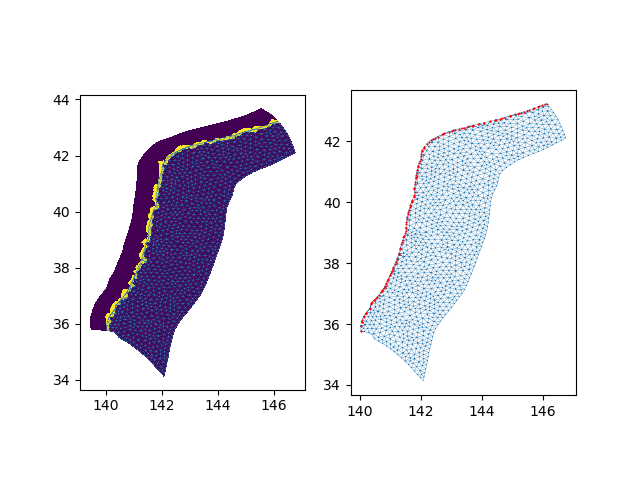

In [40]:
# expand clipped fault mesh
fault = {}
fault["points"] = new_points
fault["verts"] = total_verts

# Expand mesh coordinates
fault["lon1"] = fault["points"][fault["verts"][:, 0], 0]
fault["lon2"] = fault["points"][fault["verts"][:, 1], 0]
fault["lon3"] = fault["points"][fault["verts"][:, 2], 0]
fault["lat1"] = fault["points"][fault["verts"][:, 0], 1]
fault["lat2"] = fault["points"][fault["verts"][:, 1], 1]
fault["lat3"] = fault["points"][fault["verts"][:, 2], 1]
fault["dep1"] = fault["points"][fault["verts"][:, 0], 2]
fault["dep2"] = fault["points"][fault["verts"][:, 1], 2]
fault["dep3"] = fault["points"][fault["verts"][:, 2], 2]
fault["centroids"] = np.mean(fault["points"][fault["verts"], :], axis=1)

# Cartesian coordinates in meters
fault["x1"], fault["y1"], fault["z1"] = sph2cart(
    fault["lon1"],
    fault["lat1"],
    RADIUS_EARTH + KM2M * fault["dep1"],
)
fault["x2"], fault["y2"], fault["z2"] = sph2cart(
    fault["lon2"],
    fault["lat2"],
    RADIUS_EARTH + KM2M * fault["dep2"],
)
fault["x3"], fault["y3"], fault["z3"] = sph2cart(
    fault["lon3"],
    fault["lat3"],
    RADIUS_EARTH + KM2M * fault["dep3"],
)
# Cartesian triangle centroids
fault["x_centroid"] = (fault["x1"] + fault["x2"] + fault["x3"]) / 3.0
fault["y_centroid"] = (fault["y1"] + fault["y2"] + fault["y3"]) / 3.0
fault["z_centroid"] = (fault["z1"] + fault["z2"] + fault["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(fault["lon2"] - fault["lon1"]), np.deg2rad(fault["lat2"] - fault["lat1"]), (1 + KM2M * fault["dep2"] / RADIUS_EARTH) - (1 + KM2M * fault["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(fault["lon3"] - fault["lon1"]), np.deg2rad(fault["lat3"] - fault["lat1"]), (1 + KM2M * fault["dep3"] / RADIUS_EARTH) - (1 + KM2M * fault["dep1"] / RADIUS_EARTH)])
fault["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(fault["nv"][:, 0], fault["nv"][:, 1], fault["nv"][:, 2])
fault["strike"] = wrap2360(-np.rad2deg(azimuth))
fault["dip"] = 90 - np.rad2deg(elevation)
fault["dip_flag"] = fault["dip"] != 90

# Draw the fault 
plt.close('all')
fig, ax = plt.subplots(1, 2)
ax[0].tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.25, facecolors=bool_mask)
ax[0].triplot(fault["points"][:,0], fault["points"][:,1], fault["verts"], linewidth=0.25)
ax[0].set_aspect("equal")

ax[1].triplot(fault["points"][:,0], fault["points"][:,1], fault["verts"], linewidth=0.25)
ax[1].scatter(depth_contour[:,0], depth_contour[:,1], s=0.1, marker='*', color = 'r')
ax[1].set_aspect("equal")
plt.show()

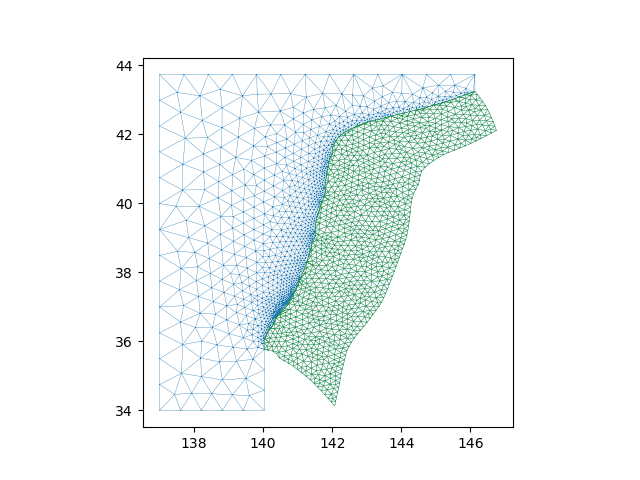

In [41]:
# franken mesh sticking the CMI and Fault together
both = {}
both["points"] = np.vstack((fault["points"], horiz["points"]))
shift_val = len(fault["points"][:,0])
both["verts"] = np.vstack((fault["verts"], horiz["verts"]+shift_val))
both["centroids"] = np.vstack((fault["centroids"], horiz["centroids"]))
both["lon1"] = np.vstack((fault["lon1"].reshape(-1,1), horiz["lon1"].reshape(-1,1))).flatten()
both["lon2"] = np.vstack((fault["lon2"].reshape(-1,1), horiz["lon2"].reshape(-1,1))).flatten()
both["lon3"] = np.vstack((fault["lon3"].reshape(-1,1), horiz["lon3"].reshape(-1,1))).flatten()
both["lat1"] = np.vstack((fault["lat1"].reshape(-1,1), horiz["lat1"].reshape(-1,1))).flatten()
both["lat2"] = np.vstack((fault["lat2"].reshape(-1,1), horiz["lat2"].reshape(-1,1))).flatten()
both["lat3"] = np.vstack((fault["lat3"].reshape(-1,1), horiz["lat3"].reshape(-1,1))).flatten()
both["dep1"] = np.vstack((fault["dep1"].reshape(-1,1), horiz["dep1"].reshape(-1,1))).flatten()
both["dep2"] = np.vstack((fault["dep2"].reshape(-1,1), horiz["dep2"].reshape(-1,1))).flatten()
both["dep3"] = np.vstack((fault["dep3"].reshape(-1,1), horiz["dep3"].reshape(-1,1))).flatten()

both["x1"] = np.vstack((fault["x1"].reshape(-1,1), horiz["x1"].reshape(-1,1))).flatten()
both["y1"] = np.vstack((fault["y1"].reshape(-1,1), horiz["y1"].reshape(-1,1))).flatten()
both["z1"] = np.vstack((fault["z1"].reshape(-1,1), horiz["z1"].reshape(-1,1))).flatten()
both["x2"] = np.vstack((fault["x2"].reshape(-1,1), horiz["x2"].reshape(-1,1))).flatten()
both["y2"] = np.vstack((fault["y2"].reshape(-1,1), horiz["y2"].reshape(-1,1))).flatten()
both["z2"] = np.vstack((fault["z2"].reshape(-1,1), horiz["z2"].reshape(-1,1))).flatten()
both["x3"] = np.vstack((fault["x3"].reshape(-1,1), horiz["x3"].reshape(-1,1))).flatten()
both["y3"] = np.vstack((fault["y3"].reshape(-1,1), horiz["y3"].reshape(-1,1))).flatten()
both["z3"] = np.vstack((fault["z3"].reshape(-1,1), horiz["z3"].reshape(-1,1))).flatten()

both["x_centroid"] = np.vstack((fault["x_centroid"].reshape(-1,1), horiz["x_centroid"].reshape(-1,1))).flatten()
both["y_centroid"] = np.vstack((fault["y_centroid"].reshape(-1,1), horiz["y_centroid"].reshape(-1,1))).flatten()
both["z_centroid"] = np.vstack((fault["z_centroid"].reshape(-1,1), horiz["z_centroid"].reshape(-1,1))).flatten()

both["nv"] = np.vstack((fault["nv"], horiz["nv"]))
both["strike"] = np.vstack((fault["strike"].reshape(-1,1), horiz["strike"].reshape(-1,1))).flatten()
both["dip"] = np.vstack((fault["dip"].reshape(-1,1), horiz["dip"].reshape(-1,1))).flatten()
both["dip_flag"] = np.vstack((fault["dip_flag"].reshape(-1,1), horiz["dip_flag"].reshape(-1,1))).flatten()


plt.close('all')
fig, ax = plt.subplots()
ax.triplot(both["points"][:, 0], both["points"][:, 1], both["verts"], linewidth=0.25)
ax.triplot(fault["points"][:,0], fault["points"][:,1], fault["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()


## Inversion Code

#### Read in GPS data

In [42]:
colnames = ["station_ID", 'lon', 'lat', 'east_vel', 'north_vel', 'up_vel']
gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)

# Place stations into single array
# lat, lon, dep, but dep is always zero because they're on the ground
# reshape(3, -1) means put it into 3 rows and as many columns as data points
# then T makes it 3 columns, and as many rows as data points
obsv = np.array([gps.lon, gps.lat, 0*gps.lat]).reshape((3, -1)).T.copy()

vec_scale = 2000

plot_vectors = False
plt.close('all')
if plot_vectors:
    fig, ax = plt.subplots()
    ax.quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale)
    ax.axis("equal")
    plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/g5/qw5l7grn2kj2gj5kx6r5ppmjwpzhpc/T/ipykernel_73135/1701277885.py:2: SyntaxWarning: invalid escape sequence '\s'
  gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)


### Concatenate Meshes and calculate partial derivatives

In [43]:
import sys
sys.path.append('/Users/emiddleton/Documents/python/celeri_folder/celeri')

import celeri 
from celeri import celeri_util
from dataclasses import dataclass

# Force meshes into dataclass, using existing fields
class Mesh:
    def __init__(self, d=None):
        if d is not None:
            for key, value in d.items():
                setattr(self, key, value)

# List of classes
meshes = [Mesh(fault), Mesh(horiz)]
# meshes = [Mesh(both)]

# Quick config class
@dataclass
class Config:
    material_lambda = 30000000000
    material_mu = 30000000000
config = Config()

# Define indices for meshes in arrays, where each meshes triangle elements begin
n_tri = np.zeros(len(meshes), dtype=int)
for i in range(len(meshes)):
    n_tri[i] = len(meshes[i].lon1)
tri_end_idx = np.cumsum(n_tri) # the last triangle index, the sum of all triangle elem in both meshes
tri_beg_idx = [0, tri_end_idx[0]] # list of indexes, the beginning of the fault mesh elem, beginning of the cmi mesh elem
total_n_tri = tri_end_idx[-1] 
# gets the last element of the summation that makes up total triangles, here, the number of tri elem in the CMI

# Allocate space for slip-to-displacement array
disp_mat = np.zeros((3*len(gps.lon), 3*np.sum(n_tri)))
# Allocate space for slip-to-displacement array
smoothing_mat = np.zeros((3*np.sum(n_tri), 3*np.sum(n_tri)))

# For each mesh, fill in disp_mat with the values and not just zeros
for mesh_idx in range(len(meshes)):
    # Calculate slip to displacement partials, using geographic coordinates
    disp_mat[:, 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = celeri.spatial.get_tde_to_velocities_single_mesh(meshes, gps, config, mesh_idx)
    # Get smoothing operator

    # Indices of shared sides in this mesh
    share = celeri.spatial.get_shared_sides(meshes[mesh_idx].verts)
    # Distances between centroids of shared elements
    tri_shared_sides_distances = celeri.spatial.get_tri_shared_sides_distances(
            share,
            meshes[mesh_idx].x_centroid,
            meshes[mesh_idx].y_centroid,
            meshes[mesh_idx].z_centroid,
        )
    # Distance-scaled smoothing matrix
    smat = celeri.spatial.get_tri_smoothing_matrix(
            share, tri_shared_sides_distances
        )
    # Insert sparse matrix into full array
    smoothing_mat[3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx], 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = smat.toarray()
    # Get smoothing operator

# get rid of tensile slip columns in fault part of disp_mat and  rows/columns of smoothing matrix (needs to be square)
keep = celeri_util.get_keep_index_12(3*tri_end_idx[0])

# using the indicies of the elements to be kept, find the elements that need to be deleted
throw = []
for i in range(3*tri_beg_idx[1]):
    if np.isin(keep, i).any():
        pass
    else:
        throw.append(i)
throw=np.array(throw)

# take out the tensile columns of the subduction zone matrix, leave the CMI matrix as is
# take out tensile rows/columns of smoothing mat, leaving it a square matrix

disp_mat = np.delete(disp_mat, throw, axis=1)
smoothing_mat = np.delete(smoothing_mat, throw, axis=0)
smoothing_mat = np.delete(smoothing_mat, throw, axis=1)



Calculating cutde partials for triangles: 100%|██████████| 2031/2031 [00:06<00:00, 323.36it/s]


##### Mini test to check for flattened elements

In [31]:
# test if elem are line elem instead of triangle , if there is an error, that is GOOD

bad_cols = np.isnan(disp_mat[0,:])
bad_el = int(np.where(bad_cols)[0][0]/3)

thing = bad_el - tri_beg_idx[1]
print(np.shape(np.unique(horiz["points"][horiz["verts"][thing,:],:],axis=0))[0])
print(horiz["verts"][thing,:])

# Draw the fault 
fig, ax = plt.subplots()
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.plot(horiz["centroids"][thing,0], horiz["centroids"][thing,1], "*r")
ax.set_aspect("equal")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [44]:
# find elements on the minimum longitude and maximum latitude edge of the CMI
celeri.mesh._compute_ordered_edge_nodes(horiz) 

# Sort edge node array
sorted_edge_nodes = np.sort(horiz["ordered_edge_nodes"], 1)

min_lon = np.min(horiz["points"][:,0])
max_lat = np.max(horiz["points"][:,1])

# find the rows of points that touch the minimum longitude value
lon_indicies = np.nonzero(horiz["points"][:,0]==min_lon)
# find the vertices / elements that correspond to those minimum longitude points
far_west = np.isin(horiz["verts"], lon_indicies)

# fill in the dictionary section of "far_west" for the CMI, true/false an element is at the min lon
col = np.full((len(far_west[0:,]),2), False)
for n in range(len(far_west[0:,])):
    if far_west[n,:].any():
        col[n,0] = True
horiz["far_west"] = col[:,0]

# find the rows of points that touch the maximum latitude values
lat_indicies = np.nonzero(horiz["points"][:,1]==max_lat)
# find the verts/elem that correspond to those points
far_north = np.isin(horiz["verts"], lat_indicies)

# fill in dictionary section of "far_north" for the CMI
for p in range(len(far_north[0:,])):
    if far_north[p,:].any():
        col[p,1] = True
horiz["far_north"] = col[:,1]


#### Assemble matrices, weighting vector, and data vector

In [102]:
# Assemble matrices and create constraint matricies for edge elements of the oversized meshes

# find edge elem to constrain slip, the meshes are too large
# they're currently set up to constrain the dip slip
celeri.mesh._compute_mesh_edge_elements(fault) 
# gives an error, maybe because it's flat?
# calc edge nodes and use the far edge longitude to find which edge nodes (?)

# constraint arrays and modify element index lists
top_elem = sum(fault["top_elements"])
side_elem = sum(fault["side_elements"])
fault_constraint = np.zeros(((2*(top_elem+side_elem)), len(disp_mat[0]))) # 3xcmi elem + 2xfault elem

tri_beg_idx.append(tri_end_idx[len(meshes)-1])
tri_end_idx = np.append(tri_end_idx, [tri_end_idx[len(meshes)-1]+len(fault_constraint[0:,])], axis=0)

# locations of top and side elements
idx = np.nonzero(fault["top_elements"])[0].reshape(-1,1) # returns a row for each nonzero val
idx2 = np.nonzero(fault["side_elements"])[0].reshape(-1,1)
rows = np.vstack((idx, idx2))

for i in range(len(rows)):
    fault_constraint[2*i, 2*rows[i]] = 1
    fault_constraint[2*i +1, 2*rows[i,0] + 1] = 1

# CMI constraint matrix containing elements on the top and left edge of the plane
edge_elem = sum(horiz["far_north"]) + sum(horiz["far_west"])
horiz_constraint = np.zeros(((3*edge_elem), len(disp_mat[0])))

west_idx = np.nonzero(horiz["far_west"])[0].reshape(-1,1) # gives the row number of elements that touch the min lon value
north_idx = np.nonzero(horiz["far_north"])[0].reshape(-1,1)
horiz_rows = np.vstack((west_idx, north_idx)) # compiled rows of north/west elem

# CMI element indicies need to be shifted by the number of fault elements
shift = 2*len(fault["lon1"]) # two not three because tensile col has already been removed from fault elements

# constrain the strike, dip, and tensile slip of the edge elements of the CMI
# putting the row/col value at one for the element and its slip component means when it's multiplied 
# by the estimated slip, the result is zero in the data vector, so the trivial answer is that slip must be zero 
# I think (?)
for m in range(edge_elem):
    horiz_constraint[3*m, shift + 3*horiz_rows[m]] = 1
    horiz_constraint[3*m +1, shift + 3*horiz_rows[m]+1] = 1
    horiz_constraint[3*m +2, shift + 3*horiz_rows[m]+2] = 1

# add indicies to beg and end idx lists for weights loop later
tri_beg_idx.append(tri_end_idx[len(meshes)])
tri_end_idx = np.append(tri_end_idx, [tri_end_idx[len(meshes)]+len(horiz_constraint[0:,])], axis=0)

assembled_mat = np.vstack([disp_mat, smoothing_mat, fault_constraint, horiz_constraint]) # stick constraint array as 3rd argument

# create new indexing lists to accommodate the differences between 2*fault_elem and 3*cmi elem
fault_end = tri_end_idx[0]*2
horiz_end = fault_end + len(horiz["lon1"])*3
fault_constraint_end = horiz_end + len(fault_constraint[0:,])

all_elem_beg = [0, fault_end, horiz_end, fault_constraint_end]
all_elem_end = [all_elem_beg[1], all_elem_beg[2], all_elem_beg[3], all_elem_beg[3]+len(horiz_constraint[0:,])]

# List of smoothing weights to test
smooths = [1e-6, 100,1e6, 1e7, 1e8, 1e9, 1e10, 1e12, 1e16]

# Select a smoothing weight and apply to meshes
smoothing_weight = [smooths[8], smooths[8], smooths[1], smooths[1]] # smooth fault, smooth horiz, smooth constraints
if np.size(smoothing_weight) != (len(meshes)+2): # add one for constraint matrix
    smoothing_weight = smoothing_weight*np.ones(len(meshes)) 

# Assemble weighting vector
# Allocate space for data vector
data_vector = np.zeros((np.shape(assembled_mat)[0], 1)) # by default, the rows corresponding to constraint array are initialized as zeros
# Vector of displacements
disp_array = np.array([gps.east_vel, gps.north_vel, gps.up_vel]).reshape((3,-1)).T.copy()
data_vector[0:np.size(disp_array)] = disp_array.flatten().reshape(-1,1)


# Start with unit uncertainties 
# this puts the smoothing weight for the fault mesh and cmi mesh, and leaves gps stations as 1
weights = np.ones((np.shape(assembled_mat)[0], 1)) # might want to update when adding slip constraint
for mesh_idx in range(len(meshes)+2):
    weights[np.size(disp_array)+ all_elem_beg[mesh_idx]:np.size(disp_array)+all_elem_end[mesh_idx]] = smoothing_weight[mesh_idx]



In [63]:
# nested loop to test the different effects of different combos of smoothing weights on fault and cmi
smooths = [1e8, 1e9, 1e10, 1e12]

max_fault_slip = np.empty((len(smooths)**2, 2))
max_horiz_slip = np.empty((len(smooths)**2, 2))
m = 0 # counter
mean_residuals = np.empty((len(smooths)**2, 3))

for i in range(len(smooths)):
    for j in range(len(smooths)):
        smoothing_weight = [smooths[i], smooths[j], 1e-6, 1e-6]
        data_vector = np.zeros((np.shape(assembled_mat)[0], 1))
        disp_array = np.array([gps.east_vel, gps.north_vel, gps.up_vel]).reshape(3,-1).T.copy()
        data_vector[0:np.size(disp_array)] = disp_array.flatten().reshape(-1,1)

        weights = np.ones((np.shape(assembled_mat)[0], 1))
        for mesh_idx in range(len(meshes)+2):
            weights[np.size(disp_array)+all_elem_beg[mesh_idx]:np.size(disp_array)+all_elem_end[mesh_idx]] = smoothing_weight[mesh_idx]
        
        # perform inversion
        # Calculate model covariance
        cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

        # Estimate slip using pre-calculated covariance
        est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
        # Predict displacement at stations
        pred_disp = disp_mat.dot(est_slip) 

        # save val for max slip mag on sub and max slip mag on cmi and corresponding smoothing val
        # dip slip on the CMI represents east-west motion, where east is negative and west is positive
        slip_type = 1 # 0 = strike slip 1 = dip slip
        end_idx = 2*tri_end_idx[0] #end of fault elem beginning of cmi elem
        slip_vals = [est_slip[slip_type:end_idx:2]/100, est_slip[slip_type+ end_idx::3]/100] # dip slip values for fault and CMI, converted from cm to m

        max_fault_slip[m, 0] = np.abs(np.max(slip_vals[0]))
        max_fault_slip[m, 1] = smooths[i] # smoothing weight on the subduction zone
        max_horiz_slip[m, 0] = np.abs(np.max(slip_vals[1]))
        max_horiz_slip[m, 1] = smooths[j] # smoothing weight on CMI
        
        # save val for mean residual displacements and corresponding smoothing vals for fault and cmi

        residuals = np.empty((len(gps.lon), 3))
        actual = np.hstack((np.array(gps.east_vel).reshape(-1,1), np.array(gps.north_vel).reshape(-1,1), np.array(gps.up_vel).reshape(-1,1)))

        calc_east = pred_disp[0::3].flatten()
        calc_north = pred_disp[1::3].flatten()
        calc_up = pred_disp[2::3].flatten()

        residuals[:,0] = actual[:,0] - calc_east
        residuals[:,1] = actual[:,1] - calc_north
        residuals[:,2] = actual[:,2] - calc_up

        mean_residuals[m, 0] = np.mean(residuals)
        mean_residuals[m, 1] = smooths[i]
        mean_residuals[m, 2] = smooths[j]
        m+=1
        print(i,j)



0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


[[1.e+12 1.e+12]]


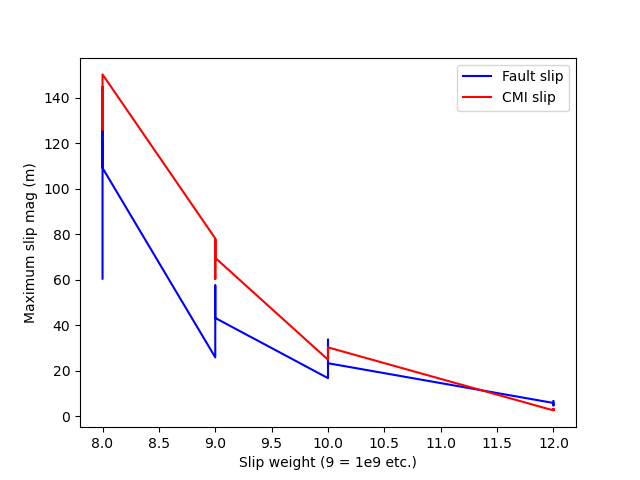

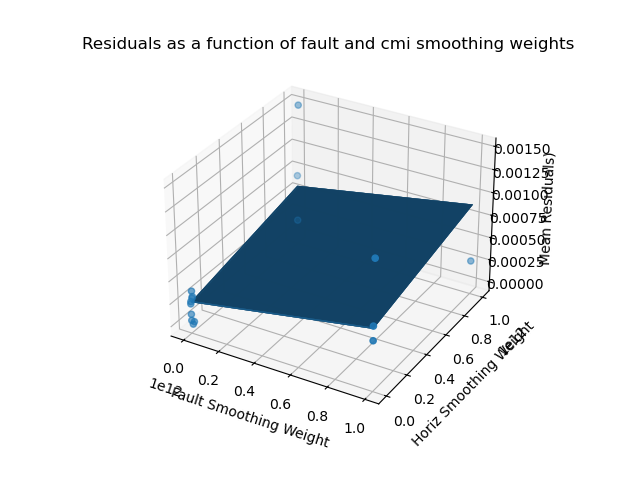

[[5.67814694e-06 1.00000000e+10 1.00000000e+08]]


In [90]:
# plot for visualizing
from mpl_toolkits.mplot3d import Axes3D

smooth_combos = np.empty_like(max_horiz_slip)
smooth_combos[:,0] = max_fault_slip[:,1]
smooth_combos[:,1] = max_horiz_slip[:,1]
avg_max_slip = ((max_horiz_slip[:,0] + max_fault_slip[:,0])/2).reshape(-1,1)
min_slip = np.min(avg_max_slip)
least_slip = np.argwhere(avg_max_slip[:,0]==min_slip)[0]
print(smooth_combos[least_slip])


sorted_idx = max_horiz_slip[:,1].argsort()
max_horiz_slip = max_horiz_slip[sorted_idx]

plt.close('all')
fig, ax = plt.subplots()
ax.plot([8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 12, 12, 12, 12], max_fault_slip[:,0], color='b', label="Fault slip")
ax.plot([8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 12, 12, 12, 12], max_horiz_slip[:,0], color='r', label="CMI slip")
ax.set_xlabel("Slip weight (9 = 1e9 etc.)")
ax.set_ylabel("Maximum slip mag (m)")
ax.axis("tight")
ax.legend()
plt.show()

# fig, ax = plt.subplots()
# ax.plot([8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 12, 12, 12, 12], mean_residuals[:,0])
# ax.set_title("Mean residuals as a function of fault slip weight")
# ax.set_xlabel("Fault slip weight")
# ax.set_ylabel("Mean residuals")
# plt.show()


# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the independent variables
x = mean_residuals[:,1] # fault smoothing weight
y = mean_residuals[:,2] # horiz smoothing weight
z = mean_residuals[:,0] # mean residuals

# Add the data points
ax.scatter(x, y, z)

# Fit a plane using np.linalg.lstsq
A = np.vstack([x, y, np.ones_like(x)]).T
plane_coef, _, _, _ = np.linalg.lstsq(A, z, rcond=None)

# Create a meshgrid for the plane
x_plane, y_plane = np.meshgrid(x, y)
z_plane = plane_coef[0] * x_plane + plane_coef[1] * y_plane + plane_coef[2]

# Add the regression plane
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.5)

# Add labels and title
ax.set_xlabel('Fault Smoothing Weight')
ax.set_ylabel('Horiz Smoothing Weight')
ax.set_zlabel('Mean Residuals)')
plt.title('Residuals as a function of fault and cmi smoothing weights')

# Show the plot
plt.show()

mean_residuals = np.abs(mean_residuals)
closest = np.min(mean_residuals[:,0])
best = np.argwhere(mean_residuals[:,0]==closest)[0]
print(mean_residuals[best])

#### Perform inversion

In [103]:
# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

# Estimate slip using pre-calculated covariance
est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
# Predict displacement at stations
pred_disp = disp_mat.dot(est_slip) 
# run to check sign convention of dip slip (neg = east pos = west on CMI)
# pred_disp = disp_mat[:, 1+all_elem_beg[1]::3].dot(est_slip[1+all_elem_beg[1]::3])

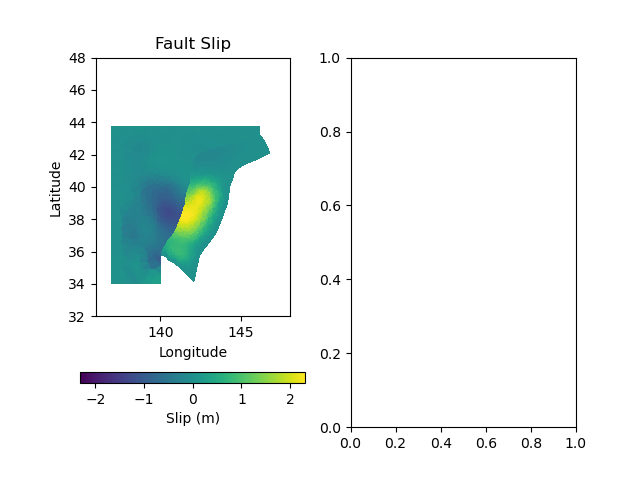

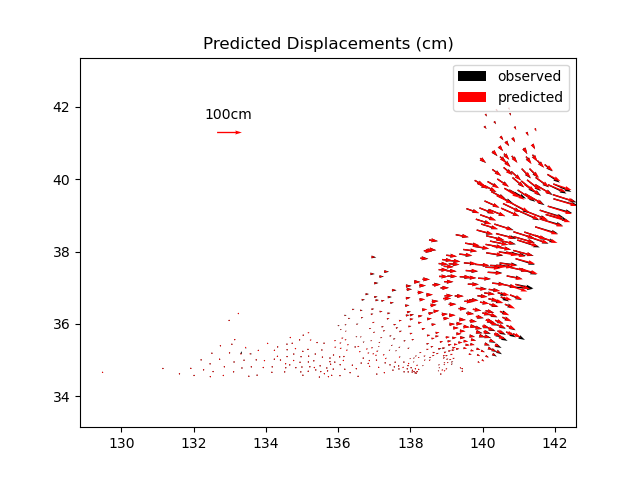

In [104]:
# plot for visualizing
xmin = 138
xmax = 148
ymin = 32
ymax = 48
plt.close('all')

# dip slip on the CMI represents east-west motion, where east is negative and west is positive
slip_type = 1 # 0 = strike slip 1 = dip slip
end_idx = 2*tri_end_idx[0] #end of fault elem beginning of cmi elem
slip_vals = [est_slip[slip_type:end_idx:2]/100, est_slip[slip_type+ end_idx::3]/100] # dip slip values for fault and CMI, converted from cm to m

max_mag_f = np.abs(np.max(slip_vals[0]))
max_mag_h = np.abs(np.max(slip_vals[1]))
if max_mag_f > max_mag_h:
    max_mag = max_mag_f
else:
    max_mag = max_mag_h

total_points = both
fig, ax = plt.subplots(1, 2)
rso = ax[0].tripcolor(both["points"][:,0], 
                      both["points"][:,1], 
                      both["verts"],
                      facecolors=(np.vstack(((slip_vals[0], slip_vals[1])))).flatten(), 
                      vmin=-max_mag, vmax=max_mag)
#ax[0].tripcolor(horiz["points"][:,0], horiz["points"][:,1], horiz["verts"], facecolors=(slip_vals[1]).flatten())
#ax[0].quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r')
cbar1 = fig.colorbar(rso, ax=ax[0], orientation='horizontal')
cbar1.set_label("Slip (m)")
ax[0].set(xlim=(xmin-2, xmax), ylim=(ymin, ymax), aspect='equal')
ax[0].title.set_text("Fault Slip") #graph 1
ax[0].set_ylabel("Latitude")
ax[0].set_xlabel("Longitude")
plt.show()


rso = ax[1].tripcolor(horiz["points"][:,0], horiz["points"][:,1], horiz["verts"], facecolors=(slip_vals[1]).flatten(), vmin=-max_mag_h, vmax=max_mag_h)
cbar1 = fig.colorbar(rso, ax=ax[1], orientation='horizontal')
cbar1.set_label("Slip (m)")
#ax[1].quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r', label="predicted")
ax[1].quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
ax[1].set(xlim=(xmin-2, xmax), ylim=(ymin, ymax), aspect='equal')
ax[1].title.set_text("CMI Slip") #graph 1
ax[1].set_ylabel("Latitude")
ax[1].set_xlabel("Longitude")


fig, ax = plt.subplots()
ax.quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
Q = ax.quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r', label="predicted")
ax.quiverkey(Q, X=0.3, Y=0.8, U=100, label="100cm", labelpos='N', color='r')
#ax.quiver(gps.lon, gps.lat, data_vector[0:1497:3], data_vector[1:1497:3], scale=vec_scale, color='b')
ax.axis("equal")
plt.title("Predicted Displacements (cm)")
plt.legend()
plt.show()

0.2113632413304067


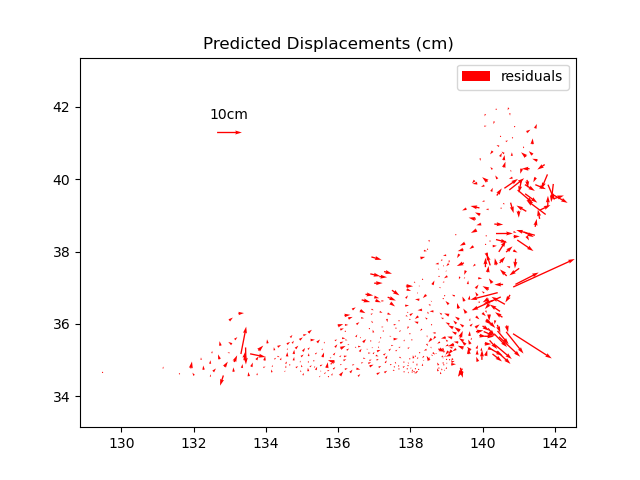

In [105]:
# calculate gps displacement residuals
# residual = actual - predicted

residuals = np.empty((len(gps.lon), 3))
actual = np.hstack((np.array(gps.east_vel).reshape(-1,1), np.array(gps.north_vel).reshape(-1,1), np.array(gps.up_vel).reshape(-1,1)))

calc_east = pred_disp[0::3].flatten()
calc_north = pred_disp[1::3].flatten()
calc_up = pred_disp[2::3].flatten()

residuals[:,0] = actual[:,0] - calc_east
residuals[:,1] = actual[:,1] - calc_north
residuals[:,2] = actual[:,2] - calc_up

print(np.mean(residuals))
plt.close('all')
fig, ax = plt.subplots()
#ax.quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
Q = ax.quiver(gps.lon, gps.lat, residuals[:,0], residuals[:,1], scale=vec_scale/10, color='r', label="residuals")
ax.quiverkey(Q, X=0.3, Y=0.8, U=10, label="10cm", labelpos='N', color='r')
#ax.quiver(gps.lon, gps.lat, data_vector[0:1497:3], data_vector[1:1497:3], scale=vec_scale, color='b')
ax.axis("equal")
plt.title("Predicted Displacements (cm)")
plt.legend()
plt.show()
